In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("harvest_data_plus_environmental_data.csv")

In [3]:
data = data[data['SEX'] == 'M'] # subsetting data to just males

## EDA:

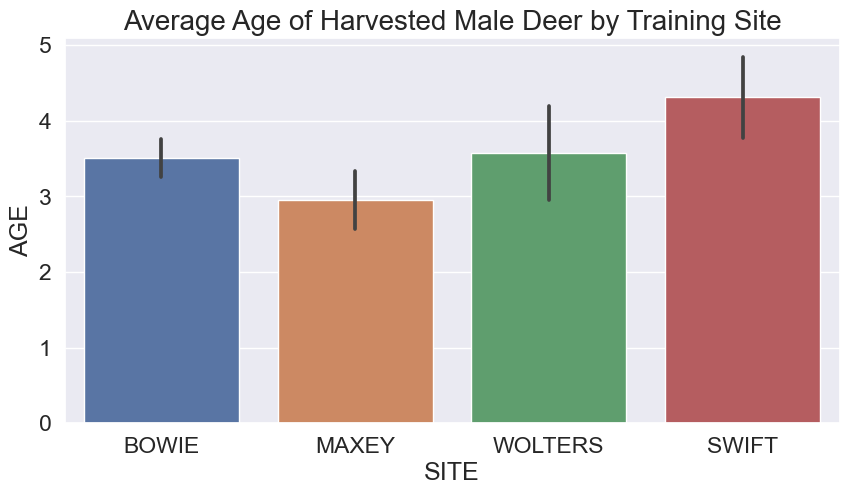

In [4]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average Age of Harvested Male Deer by Training Site', fontsize=20)
plt.show()

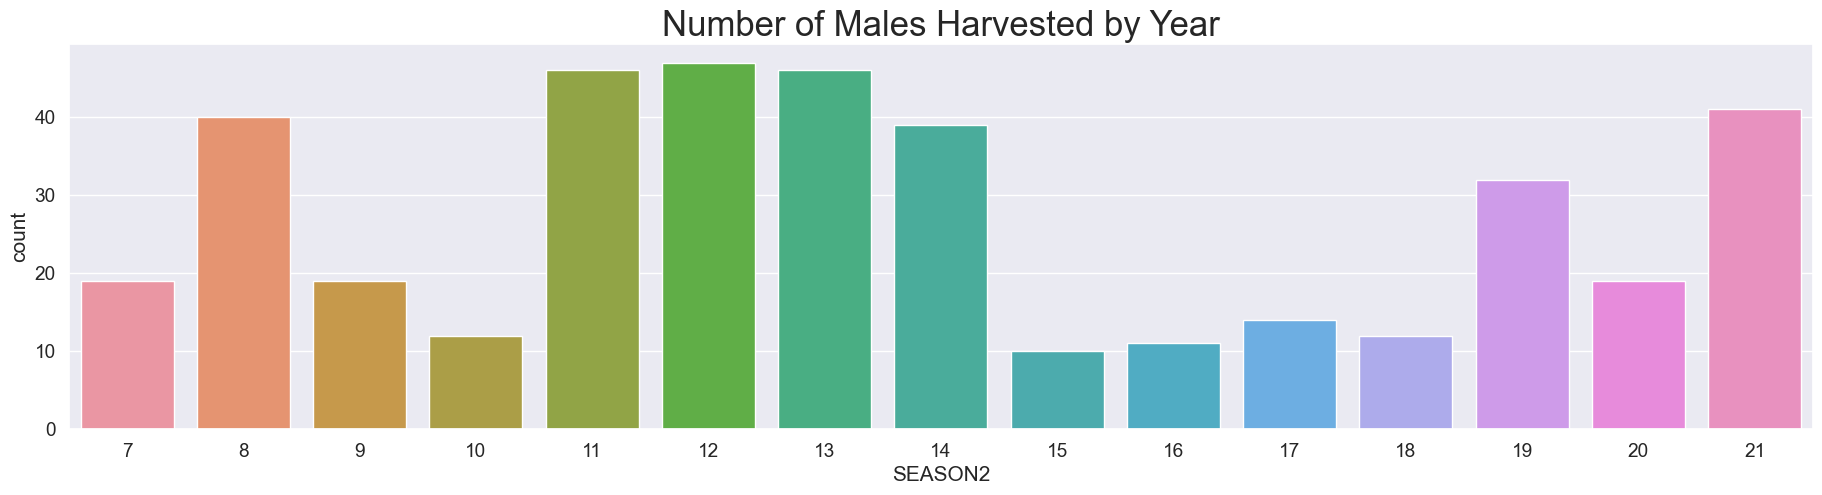

In [5]:
sns.set(rc={"figure.figsize":(22.5, 5)}, font_scale = 1.25) 
sns.countplot(x = 'SEASON2', data = data)
plt.title('Number of Males Harvested by Year', fontsize=25)
plt.show()

# the x-axis values correspond to year (e.g., '7' = 2007, '10' = 2010, and so on.)

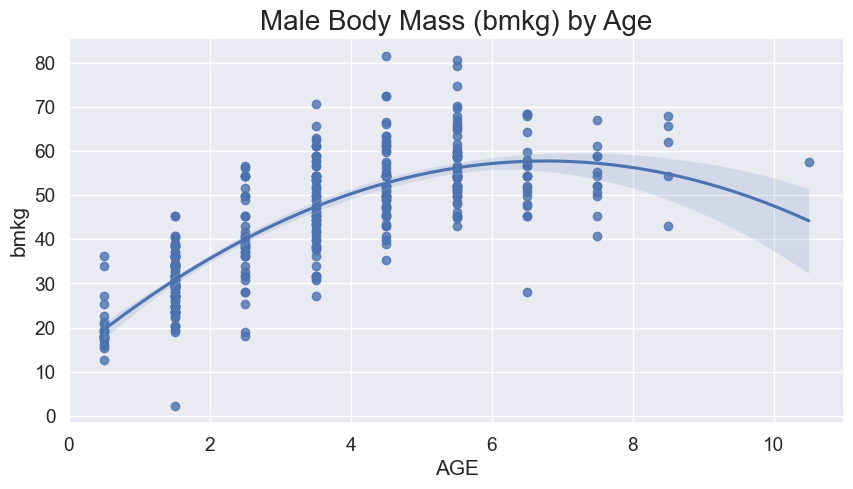

In [6]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'AGE', y = 'bmkg', data = data, order=2)
plt.title('Male Body Mass (bmkg) by Age', fontsize=20)
plt.show()

Notice the positive, curvilinear relationship between body mass and age.  However, as males reach about 6 years body mass pleateaus and begins to decline 

In [7]:
data.drop(['PREFIX-ID','SEX','DATE','ID','DATE+#','a,b,etc.','DATE TAKEN','SEASON','SEASONCAT','LIVE.BM.KG',
           'LIVE WEIGHT','BM.LB','POINTS.L','POINTS.R','SPREAD.IN','SPREAD.MM','BASAL.CIR.L.IN',
           'BASAL.CIR.L.MM','BASAL.CIR.R.IN','BASAL.CIR.R.MM ','BEAM.L.IN','BASAL.T.MM','BEAM.L.MM',
           'BEAM.R.IN','BEAM.R.MM','LACTATION','NOTES','beamtmm'],axis=1, inplace=True)

In [8]:
data['SITE'].replace(['BOWIE', 'SWIFT','MAXEY','WOLTERS'],[0, 1, 2, 3], inplace=True)

In [9]:
data.dropna(subset=['bmkg','AGE'],inplace=True)

In [10]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
SEASON2 : 0 NaN
SITE : 0 NaN
AGE : 0 NaN
bmkg : 0 NaN
rain_lag_0 : 0 NaN
rain_lag_1 : 0 NaN
rain_lag_2 : 0 NaN
rain_lag_3 : 0 NaN
rain_lag_4 : 0 NaN
rain_lag_5 : 0 NaN
temp_0 : 0 NaN
temp_1 : 0 NaN
temp_2 : 0 NaN
temp_3 : 0 NaN
temp_4 : 0 NaN
temp_5 : 0 NaN


Text(0.5, 1.0, 'Average age of harvested male deer by training site')

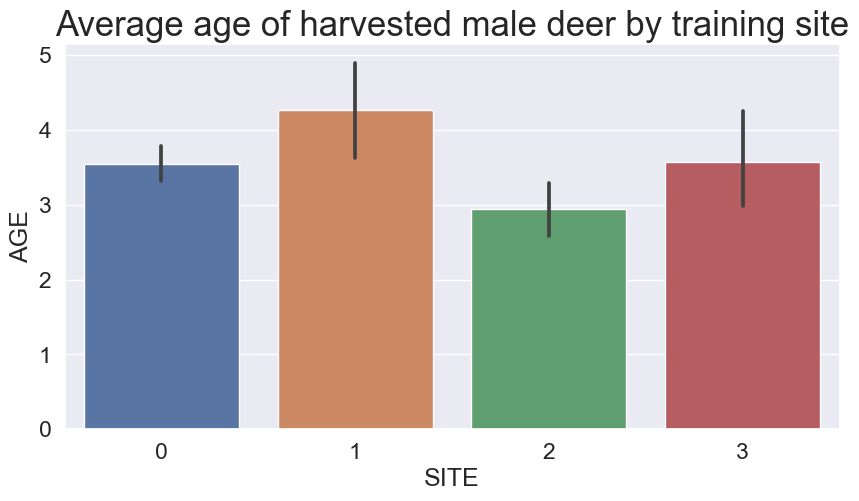

In [11]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average age of harvested male deer by training site', fontsize=25)

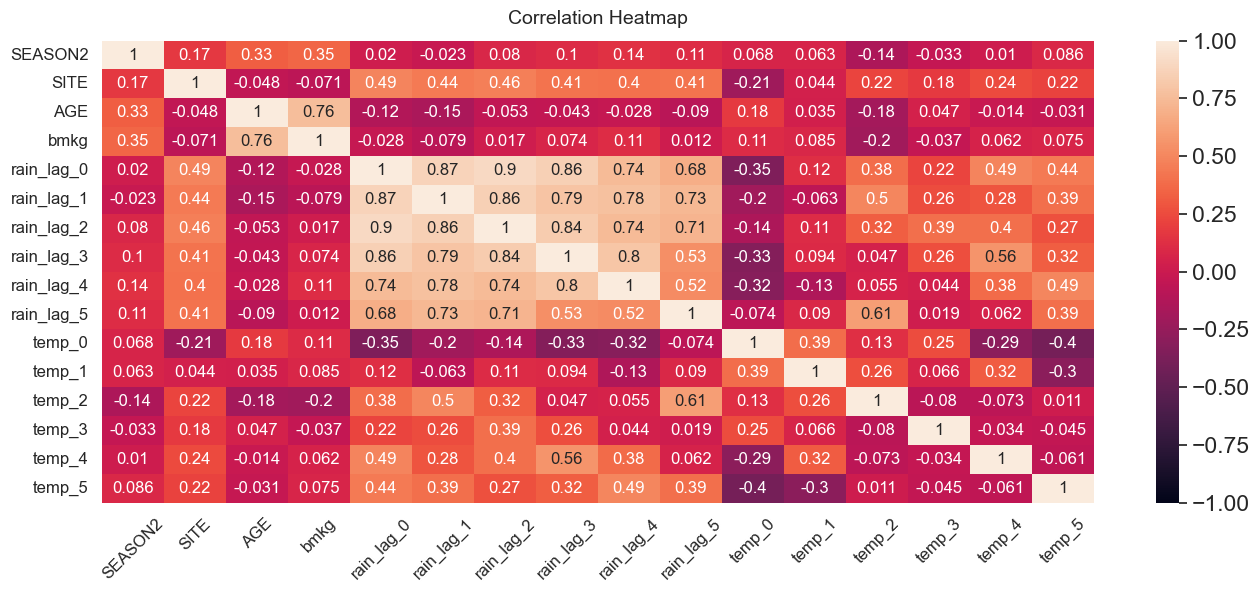

In [12]:
# Looking at correlations then dropping highly correlated variables
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

Kept rain lag 3 and 4 because they are the only rain lags that don't correlate highly with other rain lags

In [13]:
X = data[['AGE','SITE','SEASON2', 'rain_lag_3','rain_lag_4','rain_lag_5','temp_0','temp_1','temp_2','temp_3','temp_4','temp_5']] 
y = data['bmkg']

Fit several linear regression models and select final model

In [17]:
lm1 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm2 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm3 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm4 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm5 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_3 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm6 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4', data=data).fit()
lm7 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3', data=data).fit()
lm8 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2', data=data).fit()
lm9 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1', data=data).fit()
lm10 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0', data=data).fit()
lm11 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()
lm12 = smf.ols(formula='bmkg ~ AGE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()
lm13 = smf.ols(formula='bmkg ~ AGE + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()

print(lm1.aic) 
print(lm2.aic)
print(lm3.aic)
print(lm4.aic)
print(lm5.aic)
print(lm6.aic)
print(lm7.aic) # lowest AIC score
print(lm8.aic) 
print(lm9.aic)
print(lm9.aic)
print(lm10.aic)
print(lm11.aic)
print(lm12.aic)
print(lm13.aic)

2811.7258184759503
2815.2315573986734
2813.367670638905
2813.367670638905
2817.8568779308416
2810.9285880154157
2808.9327557937813
2809.121959084886
2819.6550248316526
2819.6550248316526
2826.056621817539
2824.0820393344115
2835.7141225934174
2841.656660406509


In [18]:
print(lm1.bic) 
print(lm2.bic)
print(lm3.bic)
print(lm4.bic)
print(lm5.bic)
print(lm6.bic)
print(lm7.bic)
print(lm8.bic) # lowest BIC score
print(lm9.bic)
print(lm9.bic)
print(lm10.bic)
print(lm11.bic)
print(lm12.bic)
print(lm13.bic) 

2863.31901675576
2862.8560481184977
2857.023453798744
2857.023453798744
2861.5126610906805
2858.55307873524
2852.58853895362
2848.80903468474
2855.373392871521
2855.373392871521
2857.806282297422
2851.862992254309
2859.5263679533296
2861.500198206436


AIC and BIC report lowest score for different models.  I'll summarize lm7, since it is the simpler model:

In [19]:
lm7.summary() # Not a bad r2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bmkg   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     66.93
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           1.47e-77
Time:                        16:26:20   Log-Likelihood:                -1393.5
No. Observations:                 391   AIC:                             2809.
Df Residuals:                     380   BIC:                             2853.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -43.9192     26.586     -1.652      0.099     -96.193       8.354
AGE            5.1760      0.243     21.313      0.000       4.699       5.654
SITE          -1.3897      0.455     -3.052      0.002      -2.285      -0.494
SEASON2        0.2391      0.117      2.040      0.042       0.009       0.470
rain_lag_4     0.1328      0.048      2.771      0.006       0.039       0.227
rain_lag_3    -0.0536      0.052     -1.026      0.305      -0.156       0.049
rain_lag_5     0.1353      0.047      2.888      0.004       0.043       0.227
temp_0        -0.0006      0.001     -0.557      0.578      -0.003       0.002
temp_1         0.0038      0.001      3.329      0.001       0.002       0.006
temp_2        -0.0005      0.000     -3.589      0.000      -0.001      -0.000
temp_3        -0.0002      0.000     -1.461      0.145      -0.000    6.37e-05
==============================================================================
Omnibus:                       16.008   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.074
Skew:                           0.172   Prob(JB):                     6.58e-08
Kurtosis:                       4.382   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
pred = lm7.predict(X)
print(pred)

143     27.481067
144     27.481067
147     27.481067
148     27.481067
149     27.481067
          ...    
1569    32.105732
1572    57.985852
1573    26.929708
1577    63.161876
1580    37.281756
Length: 391, dtype: float64


In [21]:
mae = mean_absolute_error(y, pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 6.4762457259033495


Contrast performance and results of linear model with a few machine learning models to see if predictors' feature importances vary among models

In [22]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

KFold cross validation to assess overfit

In [23]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [5.73956359 5.60270491 5.97924033 6.46595725 7.06984263 5.96707848
 8.06058618 5.72631926 7.43640793 7.26236341]
MAE average:  6.531006396191041


In [24]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [5.31436392 5.20095038 6.42176105 6.71835349 7.0448668  5.86541581
 9.33000961 5.46496662 7.25151474 6.77522893]
MAE average:  6.538743134563887


In [25]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [6.07981774 5.37843111 6.17814643 7.18218211 6.84161317 6.22880768
 8.23869302 5.73486664 7.77115501 6.80725143]
MAE average:  6.644096432525936


Tune hyperparamters via grid search 

In [26]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [27]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [28]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [29]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [30]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [31]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [32]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
[16:29:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [33]:
pred_gs_rf = gs_rf.predict(X)
pred_gs_gb = gs_gb.predict(X)
pred_gs_xgbr = gs_xgbr.predict(X)

mae_gs_rf = mean_absolute_error(y, pred_gs_rf)
mae_gs_gb = mean_absolute_error(y, pred_gs_gb)
mae_gs_xgbr = mean_absolute_error(y, pred_gs_xgbr)

print(mae_gs_rf) # lowest mae
print(mae_gs_gb)
print(mae_gs_xgbr)

4.305565791627439
5.195485949404504
4.214506143687262


Assess if predictors have similar feature importance scores among models

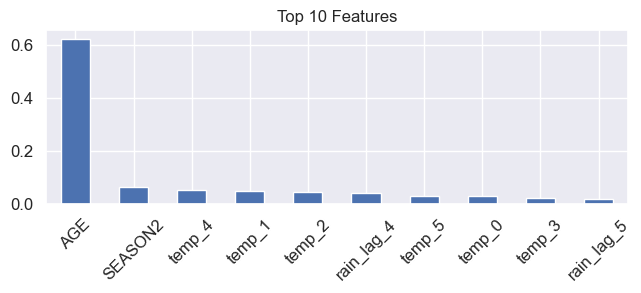

In [38]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 12
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

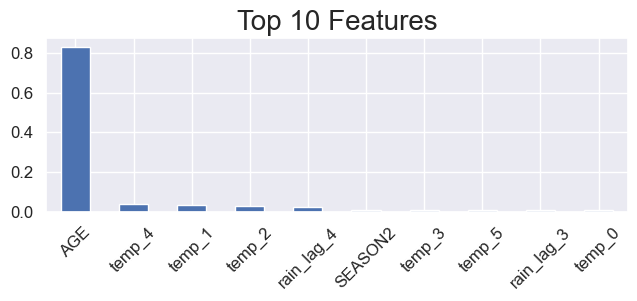

In [39]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

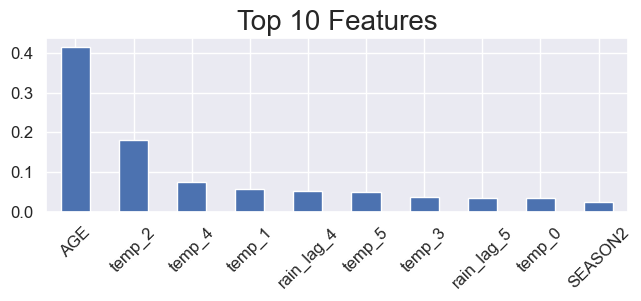

In [40]:
# lowest mae of the 3 ML models

feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

# Interpretation: Age is clearly important in predicting male body mass.  temp_2, i.e., the summed annual temperature two
# years prior was the second most important feature. 